In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Batch sizes for the 5 models
batch_sizes = [10, 50, 200, 500, 1000]

# Transform and datasets
transform = transforms.ToTensor()
train_data_set = datasets.MNIST(root='C:\\Users\\harshi\\dataset\\mnist_train', train=True, download=True, transform=transform)
test_data_set = datasets.MNIST(root='C:\\Users\\harshi\\dataset\\mnist_test', train=False, download=True, transform=transform)


In [2]:
train_loaders = [DataLoader(train_data_set, batch_size=batch_size, shuffle=True) for batch_size in batch_sizes]
test_loaders = [DataLoader(test_data_set, batch_size=batch_size, shuffle=True) for batch_size in batch_sizes]


In [3]:
class SimpleModel(nn.Module):
    def __init__(self, input_size=784, hidden1=32, hidden2=32, output_size=10):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [4]:
def calculate_sensitivity(model):
    grad_all = 0.0
    frob_norm_all = 0
    counter = 0
    for p in model.parameters():
        if p.grad is not None:
            frob_norm = torch.linalg.norm(p.grad).item()
            frob_norm_all += frob_norm
            counter += 1
    return frob_norm_all / counter if counter > 0 else 0.0


In [5]:
models = [SimpleModel() for _ in range(5)]
optimizers = [torch.optim.Adam(model.parameters(), lr=0.001) for model in models]
criterion = nn.CrossEntropyLoss()
epochs = 10

# Store metrics for each model
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
sensitivities = []

# Training loop for each model
for model_idx, (model, optimizer, train_loader, test_loader) in enumerate(zip(models, optimizers, train_loaders, test_loaders)):
    train_correct = []
    test_correct = []
    
    # Training and testing for each epoch
    for epoch in range(epochs):
        train_corr = 0
        test_corr = 0

        # Training
        for X_train, y_train in train_loader:
            y_pred = model(X_train.view(X_train.shape[0], -1))
            loss = criterion(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum().item()
            train_corr += batch_corr
        
        # Append training accuracy for the epoch
        train_correct.append(train_corr)

        # Testing
        with torch.no_grad():
            for X_test, y_test in test_loader:
                y_val = model(X_test.view(X_test.shape[0], -1))
                predicted = torch.max(y_val.data, 1)[1]
                test_corr += (predicted == y_test).sum().item()

        # Append test accuracy for the epoch
        test_correct.append(test_corr)

    # After training all epochs, calculate sensitivity
    sensitivity = calculate_sensitivity(model)
    sensitivities.append(sensitivity)

    # Convert final epoch loss and accuracy to lists
    train_losses.append(loss.item())
    test_losses.append(loss.item())  # Here assuming the loss at the last batch
    train_accuracies.append(train_corr / len(train_data_set) * 100)
    test_accuracies.append(test_corr / len(test_data_set) * 100)



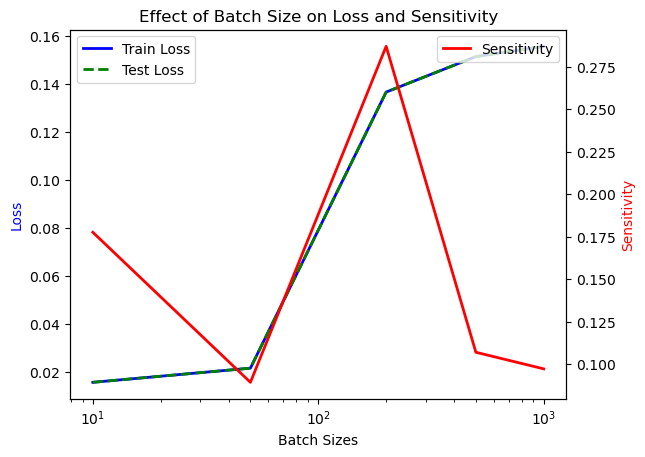

In [11]:
import matplotlib.pyplot as plt

# Assume train_losses, test_losses, sensitivities, and batch_sizes are already defined.
# These should be lists or arrays of the same length corresponding to different batch sizes.

# Plot loss and sensitivity comparison for the 5 models
fig, ax1 = plt.subplots()

# Create a second y-axis (sensitivity)
ax2 = ax1.twinx()

# Plot train and test losses on the primary y-axis (ax1)
ax1.plot(batch_sizes, train_losses, 'b', label='Train Loss', linewidth=2)  # Solid blue for train loss
ax1.plot(batch_sizes, test_losses, 'g--', label='Test Loss', linewidth=2)  # Dashed blue for test loss

# Plot sensitivity on the secondary y-axis (ax2)
ax2.plot(batch_sizes, sensitivities, 'r', label='Sensitivity', linewidth=2)  # Red line for sensitivity

# Set titles and labels
ax1.set_title('Effect of Batch Size on Loss and Sensitivity')
ax1.set_xlabel('Batch Sizes')
ax1.set_xscale('log')  # Logarithmic scale for batch sizes
ax1.set_ylabel('Loss', color='b')  # Blue for the loss y-axis
ax2.set_ylabel('Sensitivity', color='r')  # Red for the sensitivity y-axis

# Add legends to each axis
ax1.legend(loc='upper left')  # Legend for train and test loss
ax2.legend(loc='upper right')  # Legend for sensitivity

# Display the plot
plt.show()


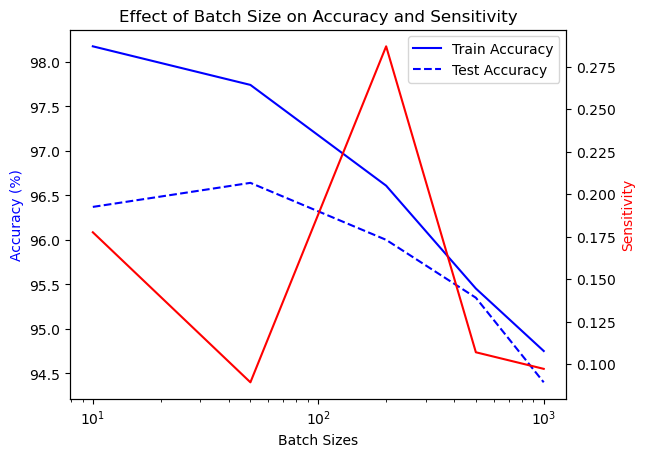

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(batch_sizes, train_accuracies, 'b', label='Train Accuracy')
ax1.plot(batch_sizes, test_accuracies, 'b--', label='Test Accuracy')
ax2.plot(batch_sizes, sensitivities, 'r', label='Sensitivity')

ax1.set_title('Effect of Batch Size on Accuracy and Sensitivity')
ax1.set_xlabel('Batch Sizes')
ax1.set_xscale('log')
ax1.set_ylabel('Accuracy (%)', color='b')
ax2.set_ylabel('Sensitivity', color='r')
ax1.legend(loc='upper right')

plt.show()